In [1]:
import glob
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import torch 
from torchvision.transforms import functional as F
from torchvision import transforms
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.patches import Polygon
from skimage.color import label2rgb
import colorsys
import random

# Model Imports
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# To Do: 

* Run the model for 100 epochs. 

* Use masks to calculate compactness ratio 
* Move to python script
* Then apply model to rasberry pi or jetson by moving predict code to script.

In [ ]:
# packages for training the model
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

# pypi packages to install
pip install labelme2coco

pip install cython
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [3]:
# New Imports
from engine import train_one_epoch, evaluate
import utils

import labelme2coco

In [4]:
!git clone https://github.com/thsant/wgisd.git

Cloning into 'wgisd'...
remote: Enumerating objects: 4248, done.
remote: Counting objects: 100% (848/848), done.
remote: Compressing objects: 100% (839/839), done.
remote: Total 4248 (delta 19), reused 820 (delta 7), pack-reused 3400
Receiving objects: 100% (4248/4248), 1.39 GiB | 44.22 MiB/s, done.
Resolving deltas: 100% (342/342), done.
Checking out files: 100% (1849/1849), done.


In [21]:
class GrapeDataset():
  def __init__(self, data_root, mode):

    self.mask_npz = sorted(glob.glob(os.path.join(data_root, "*.npz")))
    images_jpg = sorted(glob.glob(os.path.join(data_root, "*.jpg")))
    bbox_txt = sorted(glob.glob(os.path.join(data_root, "*.txt")))
    assert len(images_jpg) == len(bbox_txt)

    # In wgisd dataset not all masks are paired with bbox and imgs. 
    image_names = [os.path.splitext(os.path.basename(fp))[0] for fp in images_jpg]
    mask_names = [os.path.splitext(os.path.basename(fp))[0] for fp in self.mask_npz]
    removable_ind = [ii for ii, n in enumerate(image_names) if n not in mask_names]

    self.images_jpg, self.bbox_txt = list(), list()
    for ii in range(len(images_jpg)):
      if ii not in removable_ind:
        self.images_jpg.append(images_jpg[ii])
        self.bbox_txt.append(bbox_txt[ii])

    if mode == "train":
      print("Dataset in training mode")
      self.mask_npz = self.mask_npz[:110]
      self.images_jpg = self.images_jpg[:110]
      self.bbox_txt = self.bbox_txt[:110]
    elif mode == "valid":
      print("Dataset in evaluation mode")
      self.mask_npz = self.mask_npz[-27:]
      self.images_jpg = self.images_jpg[-27:]
      self.bbox_txt = self.bbox_txt[-27:]
    else:
      raise ValueError("mode is an invalid value")
      
    # Checks on dataset
    assert len(self.images_jpg) == len(self.mask_npz) == len(self.bbox_txt)
    for ii in range(len(self.images_jpg)):
      assert os.path.splitext(os.path.basename(self.images_jpg[ii]))[0] == \
      os.path.splitext(os.path.basename(self.bbox_txt[ii]))[0] == \
      os.path.splitext(os.path.basename(self.mask_npz[ii]))[0]
    
    print("Dataset Passed Assertions")


  def __getitem__(self, idx):

    # Handle the img
    img = cv2.imread(self.images_jpg[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = F.to_tensor(img)

    # Handle the mask
    masks = np.load(self.mask_npz[idx])["arr_0"].astype(np.uint8)
    masks = np.moveaxis(masks, -1, 0)
    num_objs = masks.shape[0]
    masks = torch.as_tensor(masks, dtype=torch.uint8)

    # Handle bboxes
    np_bbox_text = np.loadtxt(self.bbox_txt[idx], delimiter = " ", dtype = np.float32)
    bboxes = np_bbox_text[:, 1:]
    
    assert (bboxes.shape[0] == num_objs)

    _, height, width = img.shape
    scaled_boxes, areas = [], []
    for box in bboxes:
        x1 = box[0] - box[2]/2
        x2 = box[0] + box[2]/2
        y1 = box[1] - box[3]/2
        y2 = box[1] + box[3]/2
        scaled_boxes.append([x1 * width, y1 * height, x2 * width, y2 * height])
        areas.append((x2 * width - x1 * width) * (y2 * height - y1 * height))

    
    scaled_boxes = torch.as_tensor(scaled_boxes, dtype=torch.float32)
    areas = torch.as_tensor(areas, dtype = torch.float32)

    #Create labels from masks
    labels = torch.ones((num_objs,), dtype=torch.int64)
    image_id = torch.tensor([idx])
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target = {
            "boxes": scaled_boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": areas,
            "iscrowd": iscrowd
        }
    
    return img, target

  def __len__(self):
    return len(self.images_jpg)


In [22]:
train_batch_size = 2
valid_batch_size = 2

def collate_fn(batch):
  return tuple([list(a) for a in zip(*batch)])

grape_Dataset_train = GrapeDataset("/content/wgisd/data", mode = "train")
grape_Dataset_valid = GrapeDataset("/content/wgisd/data", mode = "valid")
train_loader = torch.utils.data.DataLoader(grape_Dataset_train, batch_size = train_batch_size, shuffle = False, collate_fn = collate_fn)
valid_loader = torch.utils.data.DataLoader(grape_Dataset_valid, batch_size = valid_batch_size, shuffle = False, collate_fn = collate_fn)

Dataset in training mode
Dataset Passed Assertions
Dataset in evaluation mode
Dataset Passed Assertions


In [23]:
print(grape_Dataset_train.images_jpg)

['/content/wgisd/data/CDY_2015.jpg', '/content/wgisd/data/CDY_2017.jpg', '/content/wgisd/data/CDY_2018.jpg', '/content/wgisd/data/CDY_20180427_152937457_BURST000_COVER_TOP.jpg', '/content/wgisd/data/CDY_20180427_153021423_BURST001.jpg', '/content/wgisd/data/CDY_20180427_153144437_BURST000_COVER_TOP.jpg', '/content/wgisd/data/CDY_20180427_153310519_BURST000_COVER_TOP.jpg', '/content/wgisd/data/CDY_2019.jpg', '/content/wgisd/data/CDY_2024.jpg', '/content/wgisd/data/CDY_2027.jpg', '/content/wgisd/data/CDY_2028.jpg', '/content/wgisd/data/CDY_2031.jpg', '/content/wgisd/data/CDY_2034.jpg', '/content/wgisd/data/CDY_2040.jpg', '/content/wgisd/data/CDY_2042.jpg', '/content/wgisd/data/CDY_2043.jpg', '/content/wgisd/data/CDY_2046.jpg', '/content/wgisd/data/CDY_2048.jpg', '/content/wgisd/data/CDY_2050.jpg', '/content/wgisd/data/CDY_2051.jpg', '/content/wgisd/data/CDY_2052.jpg', '/content/wgisd/data/CDY_2054.jpg', '/content/wgisd/data/CDY_2056.jpg', '/content/wgisd/data/CDY_2061.jpg', '/content/wgi

In [24]:
print(grape_Dataset_valid.images_jpg)

['/content/wgisd/data/SVB_20180427_151954938_HDR.jpg', '/content/wgisd/data/SVB_20180427_152106643_HDR.jpg', '/content/wgisd/data/SVB_20180427_152328332_HDR.jpg', '/content/wgisd/data/SVB_20180427_152414932_HDR.jpg', '/content/wgisd/data/SYH_2017-04-27_1233.jpg', '/content/wgisd/data/SYH_2017-04-27_1236.jpg', '/content/wgisd/data/SYH_2017-04-27_1238.jpg', '/content/wgisd/data/SYH_2017-04-27_1239.jpg', '/content/wgisd/data/SYH_2017-04-27_1241.jpg', '/content/wgisd/data/SYH_2017-04-27_1251.jpg', '/content/wgisd/data/SYH_2017-04-27_1253.jpg', '/content/wgisd/data/SYH_2017-04-27_1260.jpg', '/content/wgisd/data/SYH_2017-04-27_1268.jpg', '/content/wgisd/data/SYH_2017-04-27_1269.jpg', '/content/wgisd/data/SYH_2017-04-27_1271.jpg', '/content/wgisd/data/SYH_2017-04-27_1280.jpg', '/content/wgisd/data/SYH_2017-04-27_1294.jpg', '/content/wgisd/data/SYH_2017-04-27_1300.jpg', '/content/wgisd/data/SYH_2017-04-27_1304.jpg', '/content/wgisd/data/SYH_2017-04-27_1310.jpg', '/content/wgisd/data/SYH_2017-0

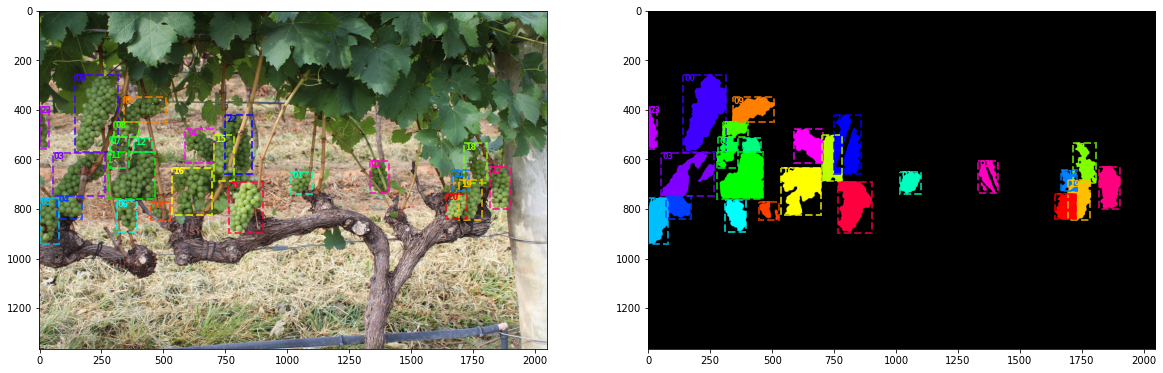

In [25]:
def random_colors(n_colors, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / n_colors, 1, brightness) for i in range(n_colors)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def show_item(img, boxes, mask):

    fig, (ax0, ax1) = plt.subplots(figsize=(20,10), ncols=2)
    # Number of instances
    n_boxes = boxes.shape[0]

    # Generate random colors
    colors = random_colors(n_boxes)

    for i, (x0, y0, x1, y1) in enumerate(boxes):
        color = np.array(colors[i])
        box_width = x1 - x0
        box_height = y1 - y0
        p = patches.Rectangle((x0, y0), box_width, box_height, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax0.add_patch(p)
        ax0.text(x0 + 5, y0 + 25, '%.2d' % i, color=color, weight='bold', size=8)

        p = patches.Rectangle((x0, y0), box_width, box_height, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax1.add_patch(p)
        ax1.text(x0 + 5, y0 + 25, '%.2d' % i, color=color, weight='bold', size=8)

        ax0.imshow(np.moveaxis(img, 0, -1))

    mask = np.moveaxis(mask, 0, -1)
    labels = np.zeros(mask.shape[0:2])
    for i in range(n_boxes):
        labels[mask[:,:,i] == 1] = i + 1
    
    mask_rgb = label2rgb(labels, colors=colors, bg_label=0)
    ax1.imshow(mask_rgb)

dataiter = iter(train_loader)
images, targets = next(dataiter)  
show_item(images[0].numpy(), targets[0]['boxes'].numpy(), targets[0]['masks'].numpy())

In [41]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained_backbone=True)
num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                  hidden_layer,
                                                  num_classes)

In [42]:
def train(model, train_loader, valid_loader, num_epochs, out_folder):
  
  # Create new folder to save all the weights
  new_folder_path = os.path.join("/content", out_folder)
  os.mkdir(new_folder_path)

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model.to(device)

  # Which params to freeze
  for param in model.backbone.parameters():
    param.requires_grad = False


  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.Adam(params, lr=0.0005, weight_decay=0.0005)

  for epoch in range(num_epochs):

      train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
      evaluate(model, valid_loader, device=device)

      if ((epoch + 1) % 10 == 0) or ((epoch + 1) == num_epochs):
        filename = "checkpoint_{}.pth".format(epoch + 1)
        SAVE_PATH = os.path.join(new_folder_path, filename)
        save_model(model, epoch, SAVE_PATH)


def save_model(model, epochs, save_path):
  model_info = {
      "model_state_dict": model.state_dict(), 
      "epochs": epochs}
  torch.save(model_info, save_path)
  print("Saved Model Checkpoint")

def load_model(path):
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained_backbone=False)
  num_classes = 2

  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  # and replace the mask predictor with a new one
  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                    hidden_layer,
                                                    num_classes)
  
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])

  return model

In [ ]:
train(model, train_loader, valid_loader, 100, "saved_models")

Epoch: [0]  [ 0/55]  eta: 0:02:50  lr: 0.000010  loss: 4.9488 (4.9488)  loss_classifier: 0.7180 (0.7180)  loss_box_reg: 0.1872 (0.1872)  loss_mask: 3.2500 (3.2500)  loss_objectness: 0.6926 (0.6926)  loss_rpn_box_reg: 0.1010 (0.1010)  time: 3.0958  data: 2.6321  max mem: 4808
Epoch: [0]  [10/55]  eta: 0:01:42  lr: 0.000102  loss: 3.1558 (3.6295)  loss_classifier: 0.3939 (0.4763)  loss_box_reg: 0.2063 (0.2106)  loss_mask: 1.5356 (2.1526)  loss_objectness: 0.6823 (0.6754)  loss_rpn_box_reg: 0.0657 (0.1147)  time: 2.2848  data: 1.8546  max mem: 4808
Epoch: [0]  [20/55]  eta: 0:01:23  lr: 0.000195  loss: 2.6912 (3.1469)  loss_classifier: 0.4467 (0.4937)  loss_box_reg: 0.4033 (0.3934)  loss_mask: 1.0123 (1.5357)  loss_objectness: 0.6291 (0.6195)  loss_rpn_box_reg: 0.0804 (0.1045)  time: 2.3626  data: 1.9087  max mem: 4808
Epoch: [0]  [30/55]  eta: 0:01:01  lr: 0.000287  loss: 2.3880 (2.8378)  loss_classifier: 0.4305 (0.4578)  loss_box_reg: 0.5619 (0.4548)  loss_mask: 0.7451 (1.2618)  loss_ob

In [28]:
train(model, train_loader, valid_loader, 100, "saved_models")

Epoch: [0]  [ 0/55]  eta: 0:02:36  lr: 0.000019  loss: 4.1790 (4.1790)  loss_classifier: 0.6830 (0.6830)  loss_box_reg: 0.0658 (0.0658)  loss_mask: 2.6247 (2.6247)  loss_objectness: 0.6956 (0.6956)  loss_rpn_box_reg: 0.1100 (0.1100)  time: 2.8504  data: 2.4288  max mem: 4280
Epoch: [0]  [10/55]  eta: 0:01:45  lr: 0.000204  loss: 2.9687 (3.1868)  loss_classifier: 0.4924 (0.5127)  loss_box_reg: 0.3027 (0.2835)  loss_mask: 1.5399 (1.6048)  loss_objectness: 0.6740 (0.6660)  loss_rpn_box_reg: 0.0646 (0.1198)  time: 2.3350  data: 1.9365  max mem: 4280
Epoch: [0]  [20/55]  eta: 0:01:25  lr: 0.000390  loss: 2.6190 (2.8456)  loss_classifier: 0.4569 (0.4947)  loss_box_reg: 0.5406 (0.5057)  loss_mask: 0.7665 (1.1649)  loss_objectness: 0.5750 (0.5701)  loss_rpn_box_reg: 0.0822 (0.1103)  time: 2.4123  data: 1.9846  max mem: 4280
Epoch: [0]  [30/55]  eta: 0:01:01  lr: 0.000575  loss: 2.1676 (2.6448)  loss_classifier: 0.4330 (0.4738)  loss_box_reg: 0.7351 (0.5498)  loss_mask: 0.6166 (0.9833)  loss_ob

KeyboardInterrupt: ignored

In [ ]:
save_model(model, 5, "/content/prac_weights.pth")

Saved Model


In [ ]:
net = load_model("/content/prac_weights.pth")

In [ ]:
def get_model_out(model, img):

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  assert type(img) == np.ndarray, "Only accepts numpy images"

  img = transforms.ToTensor()(img)
  img = img.unsqueeze(0)
  img = img.to(device)
  model.to(device)
  model.eval()

  out = model(img)

  return out

def run_model_img_path(model, img_path):

  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  out = get_model_out(model, img)
  return out

def draw_boxes(boxes):
    for i, box in enumerate(boxes):
        color =
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
    return image

def plot_mask(out, return_img = False):
  image = np.zeros((out[0]["masks"].size(2), out[0]["masks"].size(3)))
  for mask_i in range(out[0]["masks"].size(0)):
    image += out[0]["masks"][mask_i, 0].cpu().detach().numpy()
  if return_img:
    return image
  else:
    plt.imshow(image)

def plot_bbox_on_mask(out, mask_image):
  mask_image = cv2.cvtColor(mask_image, cv2.COLOR_GRAY2RGB)
  color = (255, 0, 0)
  for box in out[0]["boxes"]:
    cv2.rectangle(
            mask_image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
  
  plt.imshow(mask_image)

In [ ]:
def calculate_compactness_ratio(out):
  
  # Do NMS thresholding on the boxes



  # Go through the pixels in every bounding box

In [ ]:
out = run_model_img_path(model, "/content/wgisd/data/CDY_2015.jpg")

In [ ]:
out[0]["masks"].size(0)

97

In [ ]:
out[0]["boxes"].size(0)

97

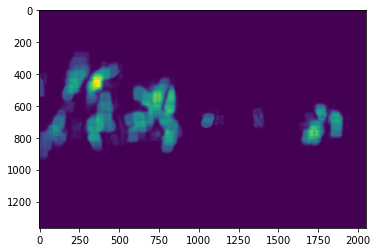

In [ ]:
plot_mask(out)

In [ ]:
img = cv2.cvtColor(cv2.imread("/content/IMG_0458.JPEG"), cv2.COLOR_BGR2GRAY)

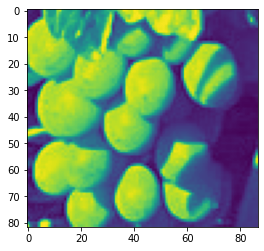

In [ ]:
plt.imshow(img)

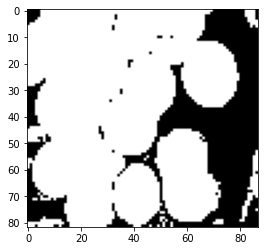

In [ ]:
img = cv2.cvtColor(cv2.imread("/content/IMG_0458.JPEG"), cv2.COLOR_BGR2GRAY)
output = img.copy()
ret, thresh = cv2.threshold(img,45,255,0)
plt.imshow(thresh, cmap = "gray")
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
def find_cluster_ratio(thresh):
  thresh = thresh / 255.0
  print(thresh.sum())

In [ ]:
find_cluster_ratio(thresh)

5193.0
